In [1]:
import pickle
import numpy as np
import pandas as pd
from keras.models import model_from_json
from collections import defaultdict
from tqdm import tqdm_notebook

Using TensorFlow backend.


## Load trained models and data

In [2]:
with open('../data/yelp_classification_training.pkl', 'rb') as out:
    training = pickle.load(out)

In [3]:
with open('../data/yelp_classification_experiments.pkl', 'rb') as out:
    saved_models = pickle.load(out)

In [4]:
experiments = {}
for k, v in saved_models.items():
    s = {}
    for model_name, model in v.items():
        if model_name == 'DNN':
            m = model_from_json(model)
            m.load_weights("../data/{}_{}.h5".format(k, model_name))
            s[model_name] = m
        else:
            s[model_name] = model
    experiments[k] = s

## Predict and test

In [5]:
test = 'raw_lemma_tfidf'
_, x_test, _, y_test = training[test]
out = experiments[test]['DNN'].predict(x_test)
print((out.argmax(axis=1) + 1)[:6])

[4 1 5 4 4 5]


## Example

In [6]:
for experiment, models in experiments.items():
    x_train, x_test, y_train, y_test = training[experiment]
    print('TRU', np.array(y_test[:6]))
    for model_name, model in models.items():
        if model_name == 'DNN':
            y_pred = model.predict(x_test).argmax(axis=1) + 1
        else:
            y_pred = model.predict(x_test)
        print(model_name, y_pred[:6])
    break

TRU [5 3 5 4 4 5]
DTC [4 4 5 5 5 4]
KNN [4 3 5 1 1 5]
DNN [4 1 5 3 5 5]


## Get precision and recall

In [7]:
from sklearn.metrics import precision_recall_fscore_support as prfs

### Example

In [8]:
test = 'raw_lemma_tfidf'
_, x_test, _, y_test = training[test]
y_pred = experiments[test]['DTC'].predict(x_test)

In [9]:
prfs(y_test, y_pred, zero_division=0)

(array([0.24074074, 0.2       , 0.20149254, 0.25670498, 0.56511057]),
 array([0.25490196, 0.16666667, 0.22689076, 0.26377953, 0.55155875]),
 array([0.24761905, 0.18181818, 0.21343874, 0.26019417, 0.55825243]),
 array([102, 108, 119, 254, 417]))

In [10]:
W = []
P = {}
measures = ['precision', 'recall', 'fscore', 'support']
exp = tqdm_notebook(experiments.items())
for experiment, models in exp:
    x_train, x_test, y_train, y_test = training[experiment]
    predictions = {}
    for model_name, model in models.items():
        if model_name == 'DNN':
            y_pred = model.predict(x_test).argmax(axis=1) + 1
        else:
            y_pred = model.predict(x_test)
        predictions[model_name] = (y_test, y_pred)
        scores = prfs(y_test, y_pred, zero_division=0)
        for j in range(5):
            O = {}
            O['experiment'] = experiment
            O['model'] = model_name
            O['class'] = j + 1
            for i, s in enumerate(measures):
                O[s] = scores[i][j]
            W.append(O)
    P[experiment] = predictions

In [11]:
K = pd.DataFrame(W)

In [12]:
K.head()

,experiment,model,class,precision,recall,fscore,support
0,raw_text_tfidf,DTC,1,0.294737,0.274510,0.284264,102
1,raw_text_tfidf,DTC,2,0.189474,0.166667,0.177340,108
2,raw_text_tfidf,DTC,3,0.218750,0.294118,0.250896,119
3,raw_text_tfidf,DTC,4,0.295833,0.279528,0.287449,254
4,raw_text_tfidf,DTC,5,0.575610,0.565947,0.570738,417


## Save

In [13]:
K.to_excel('../data/classification_report.xlsx')
with open('../data/predictions.pkl', 'wb') as out:
    pickle.dump(P, out)

## Load

In [14]:
with open('../data/predictions.pkl', 'rb') as out:
    P = pickle.load(out)
R = pd.read_excel('../data/classification_report.xlsx', index_col=0, header=0)

In [15]:
R.head()

,experiment,model,class,precision,recall,fscore,support
0,raw_text_tfidf,DTC,1,0.294737,0.274510,0.284264,102
1,raw_text_tfidf,DTC,2,0.189474,0.166667,0.177340,108
2,raw_text_tfidf,DTC,3,0.218750,0.294118,0.250896,119
3,raw_text_tfidf,DTC,4,0.295833,0.279528,0.287449,254
4,raw_text_tfidf,DTC,5,0.575610,0.565947,0.570738,417


In [16]:
R[(R.experiment == 'raw_lemma_tfidf') & (R['class'] == 5)]

,experiment,model,class,precision,recall,fscore,support
19,raw_lemma_tfidf,DTC,5,0.565111,0.551559,0.558252,417
24,raw_lemma_tfidf,KNN,5,0.603834,0.453237,0.517808,417
29,raw_lemma_tfidf,DNN,5,0.682975,0.836930,0.752155,417


In [17]:
R[(R.model == 'DNN') & (R['class'] == 5)]

,experiment,model,class,precision,recall,fscore,support
14,raw_text_tfidf,DNN,5,0.694949,0.824940,0.754386,417
29,raw_lemma_tfidf,DNN,5,0.682975,0.836930,0.752155,417
44,pos_text_tfidf,DNN,5,0.621505,0.704878,0.660571,410
59,pos_lemma_tfidf,DNN,5,0.591071,0.807317,0.682474,410
74,dep_text_tfidf,DNN,5,0.580139,0.800481,0.672727,416
89,dep_lemma_tfidf,DNN,5,0.576531,0.814904,0.675299,416
104,raw_text_sentiwn,DNN,5,0.670611,0.815348,0.735931,417
119,raw_lemma_sentiwn,DNN,5,0.642606,0.875300,0.741117,417
134,pos_text_sentiwn,DNN,5,0.520000,0.824390,0.637736,410
149,pos_lemma_sentiwn,DNN,5,0.502786,0.880488,0.640071,410


In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [19]:
def cm(experiment, classifier, predictions):
    yt, yp = predictions[experiment][classifier]
    return ConfusionMatrixDisplay(confusion_matrix(yt, yp), display_labels=range(1,6))

In [20]:
c = cm('raw_text_sentiwn', 'DTC', P)

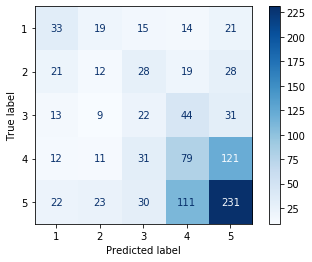

In [21]:
c.plot(values_format=".0f", cmap='Blues')
plt.show()

## Check on polarity

In [24]:
polarity = {}
for experiment, models in P.items():
    polar = {}
    for m, (y_true, y_pred) in models.items():
        yt, yp = [], []
        for x in y_true:
            if x > 3:
                yt.append(1)
            elif x < 3:
                yt.append(-1)
            else:
                yt.append(0)
        for x in y_pred:
            if x > 3:
                yp.append(1)
            elif x < 3:
                yp.append(-1)
            else:
                yp.append(0)
        polar[m] = (yt, yp)
    polarity[experiment] = polar

In [40]:
Z = []
measures = ['precision', 'recall', 'fscore', 'support']
for experiment, models in polarity.items():
    for model_name, (y_true, y_pred) in models.items():
        scores = prfs(y_true, y_pred, zero_division=0)
        for j in range(-1,2):
            O = {}
            O['experiment'] = experiment
            O['model'] = model_name
            O['class'] = j
            for i, s in enumerate(measures):
                O[s] = scores[i][j+1]
            Z.append(O)
Zp = pd.DataFrame(Z)

In [41]:
Zp.head()

,experiment,model,class,precision,recall,fscore,support
0,raw_text_tfidf,DTC,-1,0.452632,0.409524,0.430000,210
1,raw_text_tfidf,DTC,0,0.218750,0.294118,0.250896,119
2,raw_text_tfidf,DTC,1,0.789231,0.764531,0.776684,671
3,raw_text_tfidf,KNN,-1,0.368020,0.690476,0.480132,210
4,raw_text_tfidf,KNN,0,0.154930,0.184874,0.168582,119


In [43]:
Zp[(Zp.model == 'DNN') & (Zp['experiment'] == 'raw_text_tfidf')]

,experiment,model,class,precision,recall,fscore,support
6,raw_text_tfidf,DNN,-1,0.842767,0.638095,0.726287,210
7,raw_text_tfidf,DNN,0,0.371429,0.327731,0.348214,119
8,raw_text_tfidf,DNN,1,0.868207,0.952310,0.908316,671


In [46]:
c = cm('raw_text_sentiwn', 'DNN', polarity)

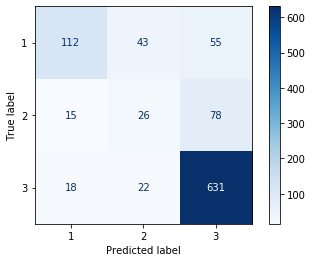

In [47]:
c.plot(values_format=".0f", cmap='Blues')
plt.show()